In [1]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import backtrader as bt
#import pyfolio as pf

import backtrader.plot.formatters as fmt
import backtrader.plot.locator as loc
import numpy as np
import matplotlib.pyplot as plt
import MyUtils
import CurrencyAdjuster

/Users/norbert/Code/miniconda3/lib/python3.6/site-packages/backtrader/plot/__init__.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/norbert/Code/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/norbert/Code/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/norbert/Code/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/norbert/Code/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/norbert/Code/miniconda3/lib/python3.6/site

In [54]:
class BenchmarkStrat(bt.Strategy):
    params = (('monthlyinvestment', 0), )
    
    def __init__(self):
        self.stratname = 'Benchmark'
        self.smaSMIC = bt.indicators.SimpleMovingAverage(self.dnames['SMICm'], period=10)
        self.invested=False
        self.lastmonth=None
    def notify_order(self, order):
        if order.status == order.Completed:
            pass
        if not order.alive():
            self.order = None  # indicate no order is pending
    def start(self):
        self.order = None

    def next(self):         
        dt = datetime.datetime.fromordinal(int(self.datas[0].datetime[0]))
        mon = dt.month
        usdchf = self.dnames['USDCHF'].close[0]
        if self.invested==False: #we are not invested yet
            self.broker.set_cash(100000/usdchf)
            print("BEN: Set initial cash value to %.2f" % self.broker.get_value())
            self.invested=True
        
        if mon != self.lastmonth: #This is the last trading day of the month and we determine what we order
            print("BEN: Adding monthly cash (%.2f) on %s" % ( self.p.monthlyinvestment, dt.date()))
            self.broker.add_cash(self.p.monthlyinvestment/usdchf)
            portfolio_value = self.broker.get_value()
            self.order_target_value(self.dnames['VTSMX'], target=portfolio_value - 4000.0)
            self.lastmonth = dt.month

class BenchmarkStratSMIC(bt.Strategy):
    params = (('monthlyinvestment', 0), )

    def __init__(self, *args, **kwargs):
        print(kwargs)
        self.stratname = 'BenchmarkSMIM'
        self.smaSMIC = bt.indicators.SimpleMovingAverage(self.dnames['SMIMm'], period=10)
        self.invested=False
        self.lastmonth=None
    def notify_order(self, order):
        if order.status == order.Completed:
            pass
        if not order.alive():
            self.order = None  # indicate no order is pending
    def start(self):
        self.order = None

    def next(self):         
        dt = datetime.datetime.fromordinal(int(self.datas[0].datetime[0]))
        mon = dt.month
        usdchf = self.dnames['USDCHF'].close[0]
        if self.invested==False: #we are not invested yet
            self.broker.set_cash(100000/usdchf)
            print("BEN: Set initial cash value to %.2f" % self.broker.get_value())
            self.invested=True
        
        if mon != self.lastmonth: #This is the last trading day of the month and we determine what we order
            print("BENS: Adding monthly cash (%.2f) on %s" % ( self.p.monthlyinvestment, dt.date()))
            self.broker.add_cash(self.p.monthlyinvestment/usdchf)
            portfolio_value = self.broker.get_value()
            self.order_target_value(self.dnames['SMIM'], target=portfolio_value - 4000.0)
            self.lastmonth = dt.month

class TimingSMASingle(bt.Strategy):
    params = (('monthlyinvestment', 0), )

    def __init__(self):
        self.smaSMIC = bt.indicators.SimpleMovingAverage(self.dnames['SMIMm'], period=10)
        self.smaSMICs = bt.indicators.SimpleMovingAverage(self.dnames['SMIM'], period=20)

        self.outofmarket = True
        self.stratname = 'SMASingleSMIM'
        self.lastmonth=None
        self.invested=False

    def notify_order(self, order):
        if order.status == order.Completed:
            pass
        if not order.alive():
            self.order = None  # indicate no order is pending
    def start(self):
        self.order = None
        
    def next(self):
        dt = datetime.datetime.fromordinal(int(self.datas[0].datetime[0]))
        mon = dt.month
        usdchf = self.dnames['USDCHF'].close[0]
        if self.invested==False: #we are not invested yet
            self.broker.set_cash(100000/usdchf)
            print("SIN: Set initial cash value to %.2f" % self.broker.get_value())
            self.invested=True
        
        if mon != self.lastmonth: #This is the last trading day of the month and we determine what we order
            print("SIN: Adding monthly cash (%.2f) on %s" % ( self.p.monthlyinvestment, dt.date()))
            self.broker.add_cash(self.p.monthlyinvestment/usdchf)
            lastclose = self.dnames['SMIMm'].close[0]
            #lastclose = self.smaSMICs[0]

            smaval = self.smaSMIC[0]
            equity_value = self.broker.get_value([self.dnames['SMIM']])
            bond_value = self.broker.get_value([self.dnames['VBMFX']])
            portfolio_value = self.broker.get_value()
            trading = False
            if (1*smaval) > lastclose and self.outofmarket==False:
                self.order_target_value(self.dnames['SMIM'], target=0.0)
                #self.order_target_value(self.dnames['VBMFX'], target=portfolio_value-4000.0) 
                self.outofmarket = True
                trading = True
            if smaval < lastclose and self.outofmarket==True:
                self.order_target_value(self.dnames['VBMFX'], target=0.0) 
                self.order_target_value(self.dnames['SMIM'], target=portfolio_value-4000.0) 
                self.outofmarket = False
                trading = True
            if trading:
                print('SIN %04d - %s - SMA: %.2f; C: %.2f; EqVal: %.2f; BdVal: %.2f; Cash: %.2f; PF: %.2f' %
                    (len(self), dt.date(), smaval, lastclose, equity_value, bond_value, portfolio_value-equity_value-bond_value, portfolio_value ))
                if self.outofmarket:
                    print("Leaving market on %s" % dt.date())
                else:
                    print("Entering market on %s" % dt.date())
            if trading==False: #We are not trading, just rebalance in case we are in the market:
                if self.outofmarket==False:
                    self.order_target_value(self.dnames['SMIM'], target=portfolio_value-4000.0)
                else:
                    #self.order_target_value(self.dnames['VBMFX'], target=portfolio_value-4000.0)
                    aa=1
            self.lastmonth = dt.month

class StFetcher(object):
    _STRATS = [TimingSMASingle, BenchmarkStratSMIC]
    def __new__(cls, *args, **kwargs):
        idx = kwargs.pop('idx')
        obj = cls._STRATS[idx](*args, **kwargs)
        return obj


In [62]:
Args = {'fromdate': datetime.datetime(1999, 2, 1),
       'todate': datetime.datetime(2018, 6, 10)}

cerebro = bt.Cerebro(stdstats=False)
#cerebro.broker.setcash(100000.0)
#print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

tframes = dict(daily=bt.TimeFrame.Days, weekly=bt.TimeFrame.Weeks,
                   monthly=bt.TimeFrame.Months)

datapath = '/Users/norbert/Code/BacktesterCode/historicdata/'
data1 = bt.feeds.YahooFinanceCSVData(
        dataname=datapath + 'SMICord.csv',
        reverse=False, swapcloses=True, **Args)
data2 = bt.feeds.YahooFinanceCSVData(
        dataname=datapath + 'VBMFX.csv',
        reverse=False, swapcloses=True, adjclose=False, **Args)
data3 = bt.feeds.YahooFinanceCSVData(
        dataname=datapath + 'SMIMTRord.csv', 
        reverse=False, swapcloses=False, **Args)
USDCHFdata = bt.feeds.YahooFinanceCSVData(
        dataname=datapath + 'USD_CHFord.csv',
        reverse=False, swapcloses=True, adjclose=False, **Args)
data1.plotinfo.plot=False
data2.plotinfo.plot=False

#data1.addfilter(CurrencyAdjuster.CurrencyDataFilter, currencydata=USDCHFdata)
#data3.addfilter(CurrencyAdjuster.CurrencyDataFilter, currencydata=USDCHFdata)

cerebro.adddata(data1, name='SMICc')
cerebro.adddata(data2, name='VBMFX')
cerebro.adddata(USDCHFdata, name='USDCHF')
cerebro.adddata(data3, name='SMIM')



cerebro.resampledata(data1, timeframe=tframes['monthly'], compression=1, name='SMICm')
cerebro.resampledata(data3, timeframe=tframes['monthly'], compression=1, name='SMIMm')

#cerebro.adddata(USDCHFdata, name='USDCHF')
#cerebro.resampledata(USDCHFdata, timeframe=tframes['monthly'], compression=1, name='USDCHF')



cerebro.addobserver(bt.obs.Broker)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.SharpeRatio)
cerebro.addobserver(CurrencyAdjuster.PortfolioCurrencyAdjuster, data=USDCHFdata)

cerebro.optstrategy(StFetcher, idx=[0, 1], monthlyinvestment=1000)

In [63]:
results = cerebro.run(optreturn=False)

{}
BEN: Set initial cash value to 62893.08
BENS: Adding monthly cash (1000.00) on 1999-12-01
SIN: Set initial cash value to 62893.08
SIN: Adding monthly cash (1000.00) on 1999-12-01
SIN 0218 - 1999-12-01 - SMA: 834.75; C: 917.83; EqVal: 0.00; BdVal: 0.00; Cash: 62893.08; PF: 62893.08
Entering market on 1999-12-01
BENS: Adding monthly cash (1000.00) on 2000-01-04
SIN: Adding monthly cash (1000.00) on 2000-01-04
BENS: Adding monthly cash (1000.00) on 2000-02-01
SIN: Adding monthly cash (1000.00) on 2000-02-01
BENS: Adding monthly cash (1000.00) on 2000-03-01
SIN: Adding monthly cash (1000.00) on 2000-03-01
BENS: Adding monthly cash (1000.00) on 2000-04-03
SIN: Adding monthly cash (1000.00) on 2000-04-03
BENS: Adding monthly cash (1000.00) on 2000-05-02
BENS: Adding monthly cash (1000.00) on 2000-06-02
SIN: Adding monthly cash (1000.00) on 2000-05-02
BENS: Adding monthly cash (1000.00) on 2000-07-03
SIN: Adding monthly cash (1000.00) on 2000-06-02
BENS: Adding monthly cash (1000.00) on 20

SIN: Adding monthly cash (1000.00) on 2005-10-03
SIN: Adding monthly cash (1000.00) on 2005-11-01
SIN: Adding monthly cash (1000.00) on 2005-12-01
SIN: Adding monthly cash (1000.00) on 2006-01-03
SIN: Adding monthly cash (1000.00) on 2006-02-01
SIN: Adding monthly cash (1000.00) on 2006-03-01
SIN: Adding monthly cash (1000.00) on 2006-04-03
SIN: Adding monthly cash (1000.00) on 2006-05-02
SIN: Adding monthly cash (1000.00) on 2006-06-01
SIN: Adding monthly cash (1000.00) on 2006-07-03
SIN: Adding monthly cash (1000.00) on 2006-08-02
SIN: Adding monthly cash (1000.00) on 2006-09-01
SIN: Adding monthly cash (1000.00) on 2006-10-02
BENS: Adding monthly cash (1000.00) on 2005-10-03
BENS: Adding monthly cash (1000.00) on 2005-11-01
SIN: Adding monthly cash (1000.00) on 2006-11-01
BENS: Adding monthly cash (1000.00) on 2005-12-01
SIN: Adding monthly cash (1000.00) on 2006-12-01
BENS: Adding monthly cash (1000.00) on 2006-01-03
SIN: Adding monthly cash (1000.00) on 2007-01-03
BENS: Adding mon

SIN: Adding monthly cash (1000.00) on 2012-05-02
BENS: Adding monthly cash (1000.00) on 2011-08-02
SIN: Adding monthly cash (1000.00) on 2012-06-01
SIN 3478 - 2012-06-01 - SMA: 1383.08; C: 1370.08; EqVal: 484086.37; BdVal: 0.00; Cash: 5987.65; PF: 490074.02
Leaving market on 2012-06-01
BENS: Adding monthly cash (1000.00) on 2011-09-01
SIN: Adding monthly cash (1000.00) on 2012-07-02
SIN 3499 - 2012-07-02 - SMA: 1387.32; C: 1391.29; EqVal: 0.00; BdVal: 0.00; Cash: 487482.63; PF: 487482.63
Entering market on 2012-07-02
BENS: Adding monthly cash (1000.00) on 2011-10-03
SIN: Adding monthly cash (1000.00) on 2012-08-02
BENS: Adding monthly cash (1000.00) on 2011-11-01
SIN: Adding monthly cash (1000.00) on 2012-09-03
BENS: Adding monthly cash (1000.00) on 2011-12-01
SIN: Adding monthly cash (1000.00) on 2012-10-01
BENS: Adding monthly cash (1000.00) on 2012-01-03
BENS: Adding monthly cash (1000.00) on 2012-02-01
SIN: Adding monthly cash (1000.00) on 2012-11-01
SIN: Adding monthly cash (1000.

BENS: Adding monthly cash (1000.00) on 2018-05-02
SIN: Adding monthly cash (1000.00) on 2017-08-02
BENS: Adding monthly cash (1000.00) on 2018-06-01
SIN: Adding monthly cash (1000.00) on 2017-09-01
SIN: Adding monthly cash (1000.00) on 2017-10-02
SIN: Adding monthly cash (1000.00) on 2017-11-01
SIN: Adding monthly cash (1000.00) on 2017-12-01
SIN: Adding monthly cash (1000.00) on 2018-01-03
SIN: Adding monthly cash (1000.00) on 2018-02-01
SIN: Adding monthly cash (1000.00) on 2018-03-01
SIN: Adding monthly cash (1000.00) on 2018-04-03
SIN: Adding monthly cash (1000.00) on 2018-05-02
SIN: Adding monthly cash (1000.00) on 2018-06-01


In [24]:
import imp
imp.reload(CurrencyAdjuster)
imp.reload(MyUtils)

<module 'MyUtils' from '/Users/norbert/Code/BacktesterCode/MyUtils.py'>

In [370]:
    cols = np.rec.fromarrays((datestr,ccmon, cccmon))

SMASingleSMIM final value: 1096081.63
BenchmarkSMIM final value: 759593.02


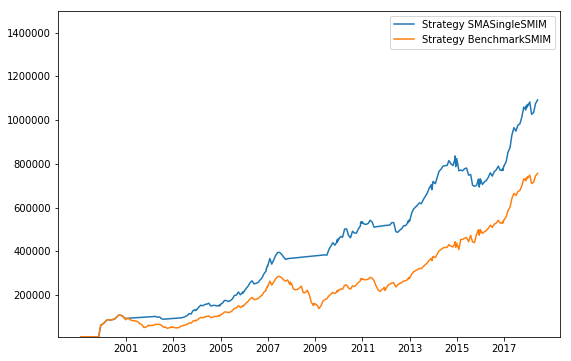

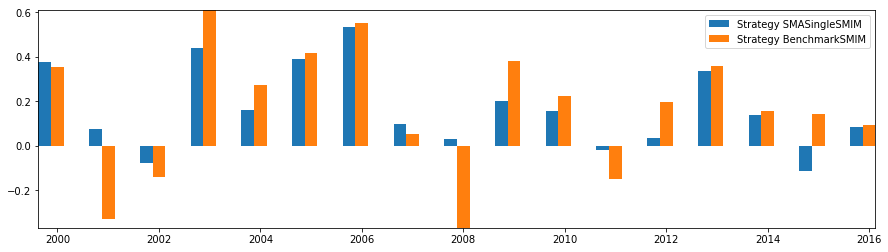

In [66]:
strats = [x[0] for x in results]  # flatten the result
plotwidth = 0.25
xreal = strats[0].datetime.plot()
xlen = len(xreal)
x = list(range(xlen))
ones = np.ones(xlen)

fmtdata = '%Y-%m-%d'
fig  = plt.figure(figsize=(9, 6))
fig2 = plt.figure(figsize=(15, 4))
ax   = fig.add_subplot(111)
ax2  = fig2.add_subplot(111)
fordata = fmt.MyDateFormatter(xreal, fmt=fmtdata)
ax.fmt_xdata = fordata
locmajor = loc.AutoDateLocator(xreal)
autofmt = loc.AutoDateFormatter(xreal, locmajor,defaultfmt=fmtdata)
plcolors = ['C0', 'C1', 'C2']
i=0
for strat in strats:
    broker = strat.observers.getbyname('broker')
    currencyadjuster = strat.observers.getbyname('portfoliocurrencyadjuster')
    cc = np.array(broker.lines[1].plot()) # Value in broker incl. cash
    ccc = np.array(currencyadjuster.lines[0].plot())
    (monidx, monthdates, ccmon) = MyUtils.ResampleDayToMonth(xreal,cc)
    (monidx, monthdates, cccmon) = MyUtils.ResampleDayToMonth(xreal,ccc)
    usdchf = strat.dnames['USDCHF'].close.plot() # Currency conversion
    startingvalue = cc[0]
    annret_dates, annret_returns = MyUtils.GetAnnualReturns(xreal,cc)
    #ax.plot(x, cc, plcolors[i], label="Strategy " + str(strat.stratname))
    ax.plot(monidx, ccmon, plcolors[i], label="Strategy " + str(strat.stratname))
    #ax.plot(monidx,cccmon, plcolors[i], linestyle="--", label="Strategy " + str(strat.stratname) + " (CHF)")
    ax2.bar(annret_dates[1:-1]+(i-1)*plotwidth,annret_returns[1:-1], width=plotwidth, label="Strategy " +str(strat.stratname))
    finalvalue = ccc[-1]
    print(str(strat.stratname) + " final value: %.2f" % finalvalue)
    # Export the strategy
    datestr = np.array([datetime.date.fromordinal(int(dd)).isoformat() for dd in monthdates])
    cols = np.rec.fromarrays((datestr,ccmon, cccmon))
   # np.savetxt("OutputData/Strat_" + strat.stratname + ".csv", cols, delimiter=',', fmt='%s, %.2f, %.2f')
    i += 1
ax.xaxis.set_major_locator(locmajor)
ax.xaxis.set_major_formatter(autofmt)
#ax.set_yscale('log')
ax.legend()
ax.set_ylim([0.1E5, 1.5E6])
ax2.autoscale(tight=True)
ax2.legend()

SMASingleSMIC final value: 620862.21
BenchmarkSMIC final value: 546620.62


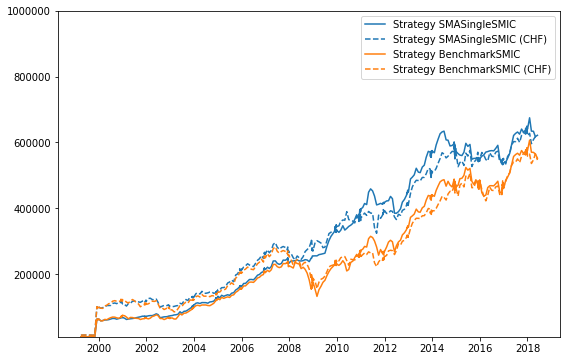

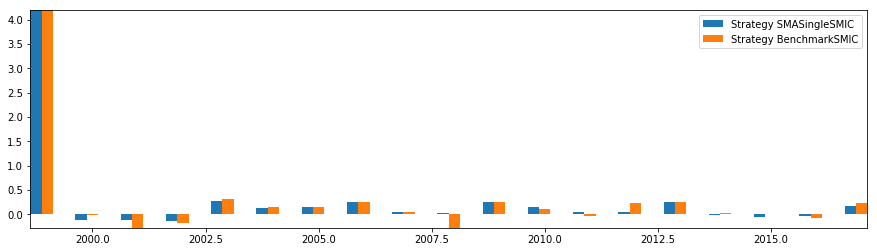

In [85]:
strats = [x[0] for x in results]  # flatten the result
plotwidth = 0.25
xreal = strats[0].datetime.plot()
xlen = len(xreal)
x = list(range(xlen))
ones = np.ones(xlen)

fmtdata = '%Y-%m-%d'
fig  = plt.figure(figsize=(9, 6))
fig2 = plt.figure(figsize=(15, 4))
ax   = fig.add_subplot(111)
ax2  = fig2.add_subplot(111)
fordata = fmt.MyDateFormatter(xreal, fmt=fmtdata)
ax.fmt_xdata = fordata
locmajor = loc.AutoDateLocator(xreal)
autofmt = loc.AutoDateFormatter(xreal, locmajor,defaultfmt=fmtdata)
plcolors = ['C0', 'C1', 'C2']
i=0
for strat in strats:
    broker = strat.observers.getbyname('broker')
    currencyadjuster = strat.observers.getbyname('portfoliocurrencyadjuster')
    cc = np.array(broker.lines[1].plot()) # Value in broker incl. cash
    ccc = np.array(currencyadjuster.lines[0].plot())
    (monidx, monthdates, ccmon) = MyUtils.ResampleDayToMonth(xreal,cc)
    (monidx, monthdates, cccmon) = MyUtils.ResampleDayToMonth(xreal,ccc)
    usdchf = strat.dnames['USDCHF'].close.plot() # Currency conversion
    startingvalue = cc[0]
    annret_dates, annret_returns = MyUtils.GetAnnualReturns(xreal,cc)
    ax.plot(monidx, ccmon, plcolors[i], label="Strategy " + str(strat.stratname))
    ax.plot(monidx,cccmon, plcolors[i], linestyle="--", label="Strategy " + str(strat.stratname) + " (CHF)")
    ax2.bar(annret_dates+(i-1)*plotwidth,annret_returns, width=plotwidth, label="Strategy " +str(strat.stratname))
    finalvalue = cc[-1]
    print(str(strat.stratname) + " final value: %.2f" % finalvalue)
    # Export the strategy
    datestr = np.array([datetime.date.fromordinal(int(dd)).isoformat() for dd in monthdates])
    cols = np.rec.fromarrays((datestr,ccmon, cccmon))
   # np.savetxt("OutputData/Strat_" + strat.stratname + ".csv", cols, delimiter=',', fmt='%s, %.2f, %.2f')
    i += 1
ax.xaxis.set_major_locator(locmajor)
ax.xaxis.set_major_formatter(autofmt)
#ax.set_yscale('log')
ax.legend()
ax.set_ylim([0.1E5, 1E6])
ax2.autoscale(tight=True)
ax2.legend()

/Users/norbert/Code/miniconda3/lib/python3.6/site-packages/backtrader/plot/plot.py:127: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/norbert/Code/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/norbert/Code/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/norbert/Code/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/norbert/Code/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/norbert/Code/miniconda3/lib/python3.6/site-pa

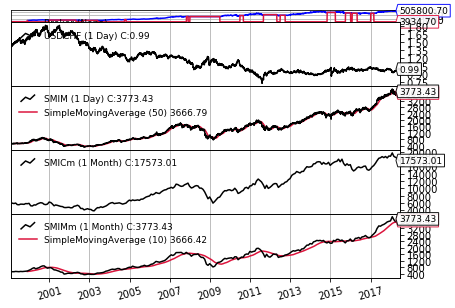

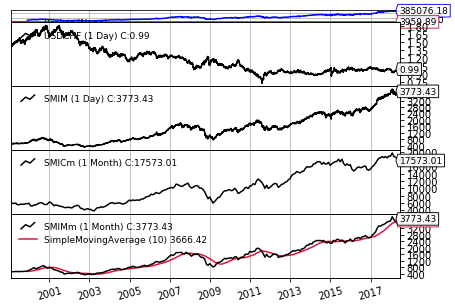

[[<Figure size 432x288 with 9 Axes>], [<Figure size 432x288 with 9 Axes>]]

In [43]:
cerebro.plot()